In this notebook, I'll be digging into the abundance of butyrate producers in donors, mostly to make a figure.

In [1]:
import pandas as pd
import feather
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

plt.style.use('seaborn-white')

# IBD studies

## Read in data

In [2]:
fmeta_jacob = '../../data/clean/jacob2017.metadata.txt'
ftidy_jacob = '../../data/clean/jacob2017.tidy_otu_w_taxonomy.txt'

fmeta_goyal = '../../data/clean/goyal2018.metadata.txt'
ftidy_goyal = '../../data/clean/goyal2018.tidy_otu_w_taxonomy.txt'

fmeta_kump = '../../data/raw/kump2018/mapping_file.txt'
ftidy_kump = '../../data/clean/kump2018.tidy_otu_w_taxonomy.txt'

In [4]:
tidyjacob = pd.read_csv(ftidy_jacob, sep='\t')
metajacob = pd.read_csv(fmeta_jacob, sep='\t', index_col=0)

tidygoyal = pd.read_csv(ftidy_goyal, sep='\t')
metagoyal = pd.read_csv(fmeta_goyal, sep='\t', index_col=0)

tidykump = pd.read_csv(ftidy_kump, sep='\t')
metakump = pd.read_csv(fmeta_kump, sep='\t', index_col=0)

In [5]:
# Combine tidy OTU tables with metadata
tidyjacob = pd.merge(tidyjacob, metajacob, left_on='sample_id', right_index=True)
tidygoyal = pd.merge(tidygoyal, metagoyal, left_on='sample_id', right_on='sample_alias')
tidykump = pd.merge(tidykump, metakump, left_on='sample_id', right_index=True)

In [19]:
# Relative abundance
tidyjacob['rel_abun'] = tidyjacob['reads'] / tidyjacob['total_reads']
tidygoyal['rel_abun'] = tidygoyal['reads'] / tidygoyal['total_reads']
tidykump['rel_abun'] = tidykump['reads'] / tidykump['total_reads']

## Find butyrate producers 

Previous notebooks checked that GG is fine to use.

In [6]:
genera = ['Odoribacter', 
          'Clostridium_XIVa',
          'Coprococcus',
          'Butyricicoccus',
          'Pseudoflavonifractor',
          'Flavonifractor',
          'Anaerostipes',
          'Roseburia',
          'Oscillibacter',
          'Faecalibacterium',
          'Subdoligranulum'
         ]

In [17]:
# Find butyrate producing OTUs

# Nested list comprehension: keep all OTU IDs which have
# any of the genera in them
butprod_jacob = [
    i for g in genera for i in tidyjacob['otu_id_gg'].unique().tolist() if g in i
    ]

butprod_goyal = [
    i for g in genera for i in tidygoyal['otu_id_gg'].unique().tolist() if g in i
    ]

butprod_kump = [
    i for g in genera for i in tidykump['otu_id_gg'].unique().tolist() if g in i
    ]

print(len(butprod_jacob), len(butprod_goyal), len(butprod_kump))

(83, 177, 167)


In [27]:
# Total abundance of butyrate producers per donor stool
# (The groupby is to keep track of other metadata of interest)
donorbut_jacob = (tidyjacob
    .query('otu_id_gg == @butprod_jacob')
    .query('donor_patient == "donor"')
    .groupby(['sample_id', 'sample_type', 'donor_patient', 'remission_w4', 'response_w4', 'patient_id'])
    .sum()
    ['rel_abun']
).reset_index()

donorbut_goyal = (tidygoyal
    .query('otu_id_gg == @butprod_goyal')
    .query('(sample_type == "D") | (sample_type == "D2")')
    .groupby(['sample_id', 'patient_id', 'sample_type', 'time_point', 
              'remission_m1', 'response_m1',
              'remission_m6', 'response_m6'])
    .sum()
    ['rel_abun']
).reset_index()

donorbut_kump = (tidykump
    .query('otu_id_gg == @butprod_kump')
    .query('Sampletype == "Donorstool"')
    .query('Sampling_day == "d1"')
    .groupby(['sample_id', 'DonorID', 'Sampling_day', 'Response'])
    .sum()
    ['rel_abun']
).reset_index()


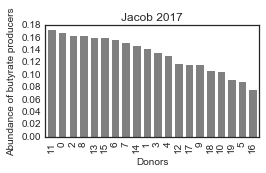

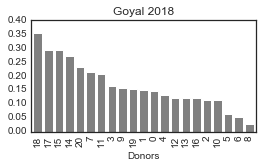

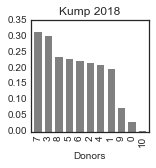

In [50]:
total_width = 10
height = 2

# To do later: make this gridspec

total_donors = float(donorbut_jacob.shape[0] + donorbut_goyal.shape[0] + donorbut_kump.shape[0])

fig, ax = plt.subplots(figsize=(total_width*donorbut_jacob.shape[0]/total_donors, height))
donorbut_jacob.sort_values(by='rel_abun', ascending=False)['rel_abun'].plot(kind='bar', color='gray', width=0.8)
ax.set_xlabel('Donors')
ax.set_ylabel('Abundance of butyrate producers')
ax.set_title('Jacob 2017')

fig, ax = plt.subplots(figsize=(total_width*donorbut_goyal.shape[0]/total_donors, height))
donorbut_goyal.sort_values(by='rel_abun', ascending=False)['rel_abun'].plot(kind='bar', color='gray', width=0.8)
ax.set_xlabel('Donors')
ax.set_ylabel('Abundance of butyrate producers')
ax.set_title('Goyal 2018')

fig, ax = plt.subplots(figsize=(total_width*donorbut_kump.shape[0]/total_donors, height))
donorbut_kump.sort_values(by='rel_abun', ascending=False)['rel_abun'].plot(kind='bar', color='gray', width=0.8)
ax.set_xlabel('Donors')
ax.set_ylabel('Abundance of butyrate producers')
ax.set_title('Kump 2018')

# BN 10 donors


In [2]:
ftidy = '../../data/clean/bn10.tidy_metabolomics.feather'
df = feather.read_dataframe(ftidy)

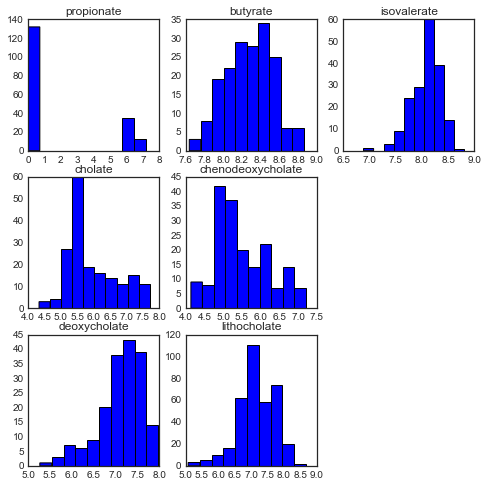

In [5]:
# For later analysis (at bottom), primary bile acids
scfas = ['propionate', 'butyrate', 'isovalerate']
bile_acids = ['cholate', 'chenodeoxycholate', 'deoxycholate', 'lithocholate']


fig, ax = plt.subplots(3, 3, figsize=(8, 8))
ax = ax.flatten()

i = 0
for s in scfas + bile_acids:
    subdf = df.query('metabolite == @s')
    ax[i].hist(np.log10(subdf['intensity'].dropna() + 1))
    ax[i].set_title(s)
    i += 1
    if s == "chenodeoxycholate":
        ax[i].set_axis_off()
        i += 1 
ax[i].set_axis_off()